<a href="https://colab.research.google.com/github/AfnanAjmal/CNN/blob/main/Last_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
from google.colab import drive
import torch
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define helper functions
def display_images(data, labels, class_names):
    """Display sample images with correct channel ordering"""
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)[0][0]
        image = data[idx]
        # Ensure image is in HWC format for display
        if image.shape[0] == 3:  # CHW format
            image = np.transpose(image, (1, 2, 0))
        axes[i].imshow(image.astype(np.float32))
        # Get the class name using the label mapping
        class_name = next((v for k, v in enumerate(class_names) if k == label), f"Class {label}")
        axes[i].set_title(f'{class_name} ({label})')
        axes[i].axis('off')
    plt.show()

def load_pth(file_path):
    raw_data = torch.load(file_path)
    return raw_data['data'].numpy(), raw_data['labels'].numpy()


# **CNN Architectures:**

In [ ]:
def cnn_architecture_1(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Block 1 - Wider filters for diverse animal features
    x = layers.SeparableConv2D(96, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(96, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)  # Higher dropout for regularization

    # Block 2 - Focus on texture patterns
    x = layers.SeparableConv2D(192, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(192, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.5)(x)

    # Feature aggregation
    x = layers.Conv2D(384, (3,3), activation='relu', padding='valid')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Classifier
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 1 Total Parameters: {model.count_params()}")
    return model


def cnn_architecture_2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Block 1 - Using separable convolutions for efficiency
    x = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 2 - Depthwise separable convolutions
    x = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Block 3 - Final feature extraction
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 2 Total Parameters: {model.count_params()}")
    return model

def cnn_architecture_3(input_shape, num_classes):
    """CNN with smaller second Conv2D layer and early dropout for better generalization."""
    inputs = layers.Input(shape=input_shape)  # Layer 1
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)  # Layer 2
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 3
    x = layers.Dropout(0.3)(x)  # Layer 4 (Early dropout)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)  # Layer 5 (Reduced filters)
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 6
    x = layers.Dropout(0.3)(x)  # Layer 7

    x = layers.Flatten()(x)  # Layer 8
    x = layers.Dense(128, activation='relu')(x)  # Layer 9
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Layer 10

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 3 Total Parameters: {model.count_params()}")
    return model

# **CNN Class:**

In [ ]:
# CNN Model Class
class CNNModel:
    def __init__(self, train_path, test_path, label_mapping, class_names, input_shape, architecture_fn, epochs=20, batch_size=32):
        self.train_path = train_path
        self.test_path = test_path
        self.label_mapping = label_mapping
        self.class_names = class_names
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.is_built = False
        self.model = None
        self.architecture_fn = architecture_fn

    def load_data(self):
        """Load data with proper channel ordering and label filtering"""
        train_data = torch.load(self.train_path)
        test_data = torch.load(self.test_path)

        def process_data(data):
            images = data['data'].numpy()
            labels = data['labels'].numpy()

            # Filter for allowed labels
            mask = np.isin(labels, list(self.label_mapping.keys()))
            filtered_images = images[mask]
            # Map labels using the provided mapping
            filtered_labels = np.array([self.label_mapping[int(label)] for label in labels[mask]])

            return filtered_images, filtered_labels

        X_train, y_train = process_data(train_data)
        X_test, y_test = process_data(test_data)
        return X_train, y_train, X_test, y_test

    def build_model(self):
        self.model = self.architecture_fn(self.input_shape, len(self.class_names))
        self.model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
        self.model.summary()
        self.is_built = True

    def train(self, X_train, y_train):
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")
        history = self.model.fit(X_train, y_train,
                               epochs=self.epochs,
                               batch_size=self.batch_size,
                               validation_split=0.1)
        return history

    def evaluate(self, X_test, y_test):
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")
        return self.model.evaluate(X_test, y_test)

    def classification_report(self, X_test, y_test):
        y_pred = np.argmax(self.model.predict(X_test), axis=1)
        print(classification_report(y_test, y_pred, target_names=self.class_names))
        return y_pred

    def plot_confusion_matrix(self, X_test, y_test):
        y_pred = self.classification_report(X_test, y_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def save(self, model_name):
        self.model.save(model_name + ".h5")

In [ ]:
# Define input shape and epochs
input_shape = (64, 64, 3)
epochs = 20
batch_size = 64

# **Model 1:**

In [ ]:
# Model 1
train_path_1 = "/content/drive/MyDrive/Merged_Datasets/fusion_model1_train.pth"
test_path_1 = "/content/drive/MyDrive/Merged_Datasets/fusion_model1_test.pth"
label_mapping_1 = {
    173: 0,   # Chihuahua
    137: 1,   # baboon
    34: 2,    # hyena
    159: 3,   # Arctic_fox
    201: 4    # lynx
}
class_names_1 = ['Chihuahua', 'baboon', 'hyena', 'Arctic_fox', 'lynx']

Displaying images for all classes:


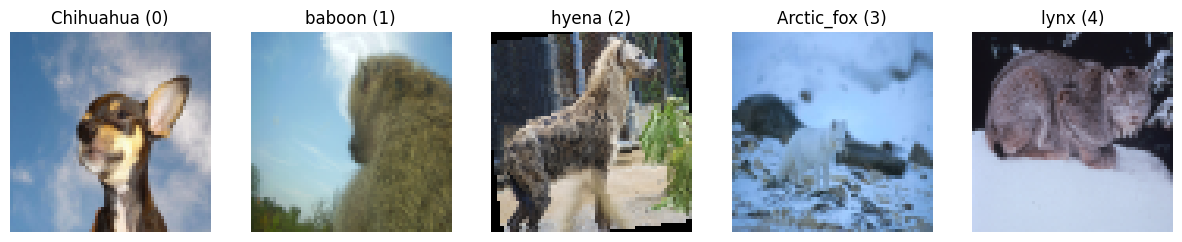

In [ ]:
# Load and display sample images
if __name__ == '__main__':
    try:
        train_data, train_labels = load_pth(train_path_1)
        print('Displaying images for all classes:')
        # Filter labels before displaying
        mask = np.isin(train_labels, list(label_mapping_1.keys()))
        filtered_images = train_data[mask]
        filtered_labels = np.array([label_mapping_1[int(label)] for label in train_labels[mask]])
        display_images(filtered_images, filtered_labels, class_names_1)
    except Exception as e:
        print(f"Error displaying images: {str(e)}")

In [ ]:
# Train Model 1
model1 = CNNModel(train_path_1, test_path_1, label_mapping_1, class_names_1, input_shape, cnn_architecture_1, epochs, batch_size)


In [ ]:
X_train1, y_train1, X_test1, y_test1 = model1.load_data()
print("Pixel range:", X_train1.min(), X_train1.max())

Pixel range: 0.0 1.0


In [ ]:
from sklearn.utils import shuffle

# For Model 1
X_train1, y_train1 = shuffle(X_train1, y_train1, random_state=42)

In [ ]:
print("\nData Shapes:")
print(f"Train: {X_train1.shape}, {y_train1.shape}")
print(f"Test: {X_test1.shape}, {y_test1.shape}")


Data Shapes:
Train: (5697, 64, 64, 3), (5697,)
Test: (450, 64, 64, 3), (450,)


In [ ]:
model1.build_model()

Model 1 Total Parameters: 835968


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 64, 64, 96)          │             411 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 64, 64, 96)          │          10,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 32, 32, 192)         │          19,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 32, 32, 192)         │          38,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 384)         │         663,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 384)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 835,968 (3.19 MB)

 Trainable params: 834,304 (3.18 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
model1.train(X_train1, y_train1)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.3676 - loss: 1.5650 - val_accuracy: 0.1825 - val_loss: 1.9026
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.4578 - loss: 1.3197 - val_accuracy: 0.2140 - val_loss: 2.2193
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5064 - loss: 1.2184 - val_accuracy: 0.2140 - val_loss: 2.2262
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5311 - loss: 1.1538 - val_accuracy: 0.2140 - val_loss: 2.7121
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5798 - loss: 1.0563 - val_accuracy: 0.2140 - val_loss: 6.3266
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6298 - loss: 0.9657 - val_accuracy: 0.2351 - val_loss: 4.7037
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6336 - loss: 0.9238 - val_accuracy: 0.1825 - val_loss: 5.1541
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6681 - loss: 0.8797 - val_accuracy: 0.1649 -

In [ ]:
model1.evaluate(X_test1, y_test1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.4559 - loss: 2.2474


[2.0348124504089355, 0.5155555605888367]

In [ ]:
model1.classification_report(X_test1, y_test1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
              precision    recall  f1-score   support

   Chihuahua       0.78      0.69      0.73        90
      baboon       0.60      0.52      0.56        90
       hyena       0.69      0.83      0.76        90
  Arctic_fox       0.85      0.81      0.83        90
        lynx       0.63      0.69      0.66        90

    accuracy                           0.71       450
   macro avg       0.71      0.71      0.71       450
weighted avg       0.71      0.71      0.71       450



array([2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 4, 4,
       0, 3, 0, 4, 2, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 1,
       2, 4, 4, 4, 4, 4, 4, 0, 4, 4, 3, 4, 2, 1, 1, 1, 1, 4, 1, 1, 2, 1,
       4, 4, 1, 4, 1, 0, 0, 1, 1, 2, 4, 1, 2, 2, 0, 4, 1, 1, 1, 1, 1, 0,
       2, 4, 0, 1, 2, 3, 3, 0, 2, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3,
       3, 4, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 4, 0, 0, 0, 3, 3, 3, 1, 3, 4, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3,
       3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 0, 0, 0, 4, 1, 0, 0, 0, 3, 0, 0, 4, 4, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 4, 4, 4, 4, 0, 0, 0,
       2, 0, 0, 0, 4, 4, 2, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4,

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

   Chihuahua       0.78      0.69      0.73        90
      baboon       0.60      0.52      0.56        90
       hyena       0.69      0.83      0.76        90
  Arctic_fox       0.85      0.81      0.83        90
        lynx       0.63      0.69      0.66        90

    accuracy                           0.71       450
   macro avg       0.71      0.71      0.71       450
weighted avg       0.71      0.71      0.71       450



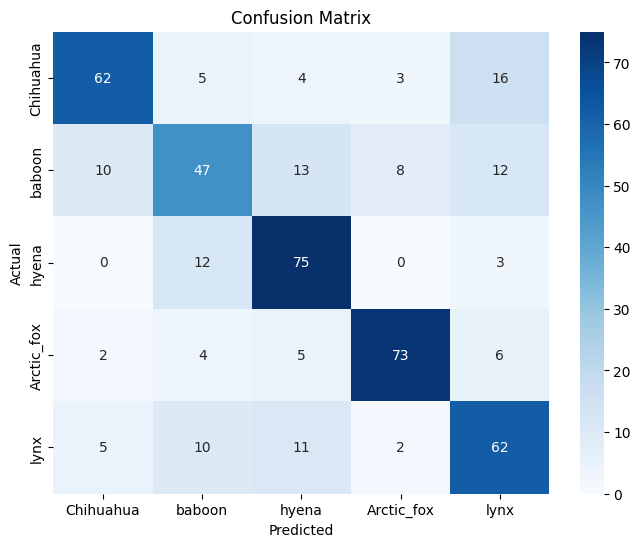

In [ ]:
model1.plot_confusion_matrix(X_test1, y_test1)

In [ ]:
model1.save("model1")

# **Model 2:**

In [ ]:
# Model 2
train_path_2 = "/content/drive/MyDrive/Merged_Datasets/fusion_model2_train.pth"
test_path_2 = "/content/drive/MyDrive/Merged_Datasets/fusion_model2_test.pth"
label_mapping_2 = {
    24: 0,   # African Elephant
    34: 1,   # Hyena
    80: 2,   # Zebra
    135: 3,  # Patas
    202: 4   # African Hunting Dog
}
class_names_2 = ['African Elephant', 'Hyena', 'Zebra', 'Patas', 'African Hunting Dog']

In [ ]:
# Train Model 2
model2 = CNNModel(train_path_2, test_path_2, label_mapping_2, class_names_2, input_shape, cnn_architecture_2, epochs, batch_size)

In [ ]:
X_train2, y_train2, X_test2, y_test2 = model2.load_data()
print("Pixel range:", X_train2.min(), X_train2.max())

Pixel range: 0.0 1.0


In [ ]:
from sklearn.utils import shuffle

# For Model 2
X_train2, y_train2 = shuffle(X_train2, y_train2, random_state=42)
X_test2, y_test2 = shuffle(X_test2, y_test2, random_state=42)


In [ ]:
print("\nData Shapes:")
print(f"Train: {X_train2.shape}, {y_train2.shape}")
print(f"Test: {X_test2.shape}, {y_test2.shape}")


Data Shapes:
Train: (5722, 64, 64, 3), (5722,)
Test: (450, 64, 64, 3), (450,)


In [ ]:
model2.build_model()

Model 2 Total Parameters: 397408


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 64, 64, 64)          │             283 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 64, 64, 64)          │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_6 (SeparableConv2D) │ (None, 32, 32, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_7 (SeparableConv2D) │ (None, 32, 32, 128)         │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 397,408 (1.52 MB)

 Trainable params: 395,616 (1.51 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
model2.train(X_train2, y_train2)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.3484 - loss: 1.7330 - val_accuracy: 0.1763 - val_loss: 1.7902
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4638 - loss: 1.3115 - val_accuracy: 0.1763 - val_loss: 2.5771
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5576 - loss: 1.1197 - val_accuracy: 0.1763 - val_loss: 2.6942
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6158 - loss: 0.9881 - val_accuracy: 0.1763 - val_loss: 4.8369
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6583 - loss: 0.8932 - val_accuracy: 0.1763 - val_loss: 5.9955
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6708 - loss: 0.8599 - val_accuracy: 0.1763 - val_loss: 7.0002
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7015 - loss: 0.7934 - val_accuracy: 0.1763 - val_loss: 4.3426
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7293 - loss: 0.7073 - val_accuracy: 0.2182 -

In [ ]:
model2.evaluate(X_test2, y_test2)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7000 - loss: 1.0512


[0.9925354719161987, 0.7133333086967468]

In [ ]:
model2.classification_report(X_test2, y_test2)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
                     precision    recall  f1-score   support

   African Elephant       0.98      0.51      0.67        90
              Hyena       0.60      0.58      0.59        90
              Zebra       0.93      0.89      0.91        90
              Patas       0.81      0.60      0.69        90
African Hunting Dog       0.55      0.99      0.70        90

           accuracy                           0.71       450
          macro avg       0.77      0.71      0.71       450
       weighted avg       0.77      0.71      0.71       450



array([2, 2, 4, 4, 2, 2, 4, 2, 4, 3, 2, 2, 1, 2, 0, 2, 4, 4, 3, 4, 4, 3,
       2, 1, 4, 2, 1, 3, 2, 4, 4, 0, 0, 4, 1, 4, 4, 2, 3, 2, 2, 2, 4, 4,
       1, 1, 4, 3, 4, 3, 4, 4, 1, 4, 1, 3, 1, 1, 4, 4, 4, 1, 1, 3, 3, 4,
       2, 1, 3, 4, 1, 1, 4, 4, 2, 4, 1, 4, 1, 1, 2, 3, 4, 4, 4, 1, 4, 0,
       1, 3, 1, 1, 3, 1, 4, 1, 4, 0, 2, 4, 1, 4, 3, 4, 4, 4, 4, 4, 1, 4,
       4, 4, 0, 4, 3, 4, 2, 2, 4, 1, 4, 1, 3, 2, 4, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 1, 2, 4, 4, 2, 4, 4, 2, 2, 1, 3, 2, 0, 2, 4, 2, 2, 2, 4, 4,
       0, 0, 2, 2, 2, 3, 4, 4, 4, 3, 2, 1, 1, 4, 3, 4, 4, 4, 1, 0, 2, 1,
       1, 1, 2, 2, 0, 3, 2, 3, 4, 4, 0, 1, 1, 1, 2, 2, 4, 1, 1, 4, 4, 4,
       4, 3, 1, 2, 3, 2, 1, 1, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 3, 2, 0,
       4, 2, 0, 0, 4, 4, 3, 1, 1, 1, 2, 2, 0, 4, 4, 3, 4, 3, 3, 1, 4, 1,
       2, 2, 2, 0, 1, 4, 4, 4, 1, 4, 2, 1, 2, 1, 1, 1, 1, 1, 0, 4, 0, 3,
       1, 3, 2, 0, 4, 4, 0, 2, 0, 3, 4, 4, 3, 4, 2, 0, 2, 2, 4, 4, 4, 2,
       0, 3, 2, 3, 3, 4, 4, 0, 2, 1, 4, 1, 0, 2, 4,

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
                     precision    recall  f1-score   support

   African Elephant       0.98      0.51      0.67        90
              Hyena       0.60      0.58      0.59        90
              Zebra       0.93      0.89      0.91        90
              Patas       0.81      0.60      0.69        90
African Hunting Dog       0.55      0.99      0.70        90

           accuracy                           0.71       450
          macro avg       0.77      0.71      0.71       450
       weighted avg       0.77      0.71      0.71       450



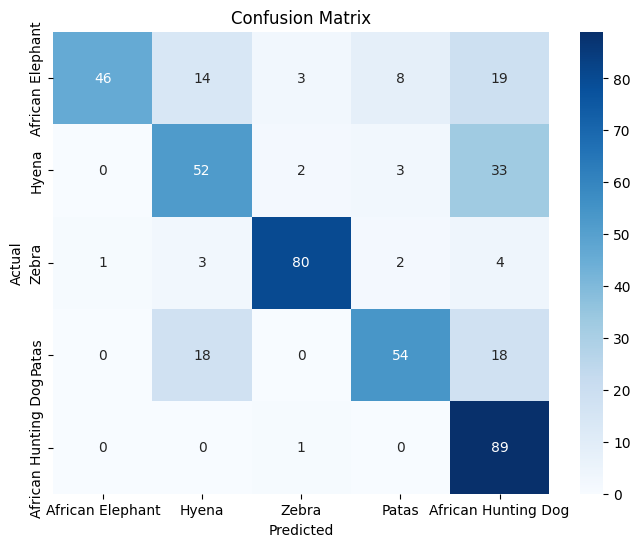

In [ ]:
model2.plot_confusion_matrix(X_test2, y_test2)

In [ ]:
model2.save("model2")

# **Model 3:**

In [ ]:
train_path_3 = "/content/drive/MyDrive/Task2_data/train_dataB_model_3.pth"
test_path_3 = "/content/drive/MyDrive/Task2_data/val_dataB_model_3.pth"

label_mapping_3 = {
    124: 0,  # Collie -> 0
    202: 1   # African Hunting Dog -> 1
}

Classes3 = ["Collie", "African Hunting Dog"]


In [ ]:
# Function to filter out unwanted classes
def filter_classes(X, y, label_mapping):
    """Filter out data and labels for classes not in the label mapping."""
    # Create a list of valid labels (keys in the label mapping)
    valid_labels = list(label_mapping.keys())

    # Filter data and labels
    mask = np.isin(y, valid_labels)
    X_filtered = X[mask]
    y_filtered = y[mask]

    # Map the labels to the new label mapping
    y_filtered = np.array([label_mapping[int(label)] for label in y_filtered])

    return X_filtered, y_filtered

In [ ]:
# Load and preprocess data for Model 3
def load_data_model_3(train_path, test_path, label_mapping):
    """Load and preprocess data for Model 3, filtering out unwanted classes."""
    # Load raw data
    train_data = torch.load(train_path, weights_only=True)
    test_data = torch.load(test_path, weights_only=True)

    # Extract data and labels
    X_train = train_data['data'].numpy()
    y_train = train_data['labels'].numpy()
    X_test = test_data['data'].numpy()
    y_test = test_data['labels'].numpy()

    # Filter out unwanted classes
    X_train, y_train = filter_classes(X_train, y_train, label_mapping)
    X_test, y_test = filter_classes(X_test, y_test, label_mapping)

    # Normalize data
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    return X_train, y_train, X_test, y_test

In [ ]:
# Load and preprocess data for Model 3
X_train3, y_train3, X_test3, y_test3 = load_data_model_3(train_path_3, test_path_3, label_mapping_3)

# Print shapes of the data
print(f"Shape of X_train3: {X_train3.shape}")
print(f"Shape of y_train3: {y_train3.shape}")
print(f"Shape of X_test3: {X_test3.shape}")
print(f"Shape of y_test3: {y_test3.shape}")


Shape of X_train3: (1273, 64, 64, 3)
Shape of y_train3: (1273,)
Shape of X_test3: (100, 64, 64, 3)
Shape of y_test3: (100,)


In [ ]:
# Train Model 3
model3 = CNNModel(train_path_3, test_path_3, label_mapping_3, Classes3, input_shape, cnn_architecture_3, epochs)


In [ ]:

# Build the model
model3.build_model()

Model 3 Total Parameters: 3287298


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,287,298 (12.54 MB)

 Trainable params: 3,287,298 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model3.train(X_train3, y_train3)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.5770 - loss: 1.0278 - val_accuracy: 0.2109 - val_loss: 0.7570
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6043 - loss: 0.6584 - val_accuracy: 0.2266 - val_loss: 0.9004
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6916 - loss: 0.5887 - val_accuracy: 0.3359 - val_loss: 0.8358
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7441 - loss: 0.5160 - val_accuracy: 0.8984 - val_loss: 0.3289
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7939 - loss: 0.4534 - val_accuracy: 0.7188 - val_loss: 0.4996
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8037 - loss: 0.4434 - val_accuracy: 0.5781 - val_loss: 0.7247
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8253 - loss: 0.3935 - val_accuracy: 0.7969 - val_loss: 0.4356
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8825 - loss: 0.3075 - val_accuracy: 0.4609 - 

In [ ]:
# Evaluate the model
model3.evaluate(X_test3, y_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9078 - loss: 0.4359


[0.4245145916938782, 0.9100000262260437]

In [ ]:
# Generate classification report
model3.classification_report(X_test3, y_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
                     precision    recall  f1-score   support

             Collie       0.90      0.92      0.91        50
African Hunting Dog       0.92      0.90      0.91        50

           accuracy                           0.91       100
          macro avg       0.91      0.91      0.91       100
       weighted avg       0.91      0.91      0.91       100



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
                     precision    recall  f1-score   support

             Collie       0.90      0.92      0.91        50
African Hunting Dog       0.92      0.90      0.91        50

           accuracy                           0.91       100
          macro avg       0.91      0.91      0.91       100
       weighted avg       0.91      0.91      0.91       100



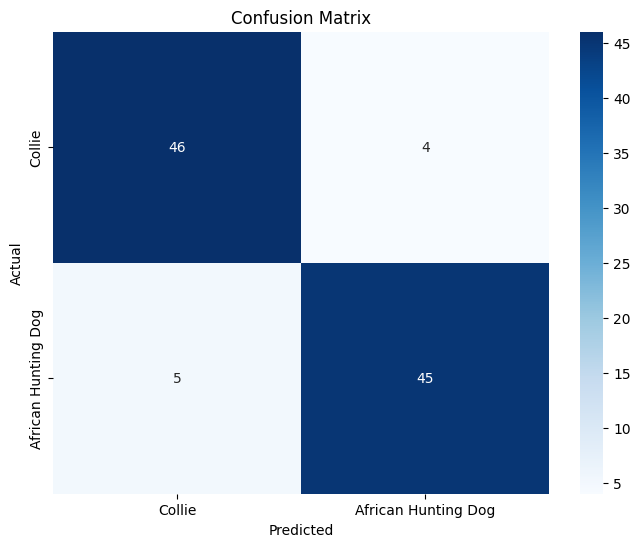

In [ ]:
# Plot confusion matrix
model3.plot_confusion_matrix(X_test3, y_test3)

In [ ]:
# Save the model
model3.save("model3")

# **Feature Level Fusion**

### **For Model 1, 2 and 3:**

In [ ]:
from keras import backend as K
import numpy as np

# Function to extract features from the penultimate layer
def extract_features(cnn_model, X):
    # Ensure the model is built by passing a dummy input through the call method

    feature_extractor = Model(inputs=cnn_model.model.input, outputs=cnn_model.model.layers[3].output)
    return feature_extractor.predict(X.astype(np.float32))


# Extract features for training data
features_train1 = extract_features(model1, X_train1)
features_train2 = extract_features(model2, X_train2)
features_train3 = extract_features(model3, X_train3)

# Extract features for testing data
features_test1 = extract_features(model1, X_test1)
features_test2 = extract_features(model2, X_test2)
features_test3 = extract_features(model3, X_test3)


print(type(features_train1))
print(features_train1.shape)
print(features_train2.shape)
print(features_test1.shape)
print(features_test2.shape)
print(features_test3.shape)

# Feature-level fusion: Concatenation
fused_train_features = np.concatenate((features_train1, features_train2,features_train3), axis=0)
fused_test_features = np.concatenate((features_test1, features_test2,features_test3), axis=0)

print("fused_train_features",len(features_train1),len(features_train2),len(features_train3),"==",len(fused_train_features))
print("fused_test_features",len(features_test1),len(features_test2),len(features_test3),"==",len(fused_test_features))
# print("fuesed_test_feature")

# Define labels for fused model

y_train_fused = np.concatenate((y_train1, y_train2,y_train3), axis=0)
y_test_fused = np.concatenate((y_test1, y_test2,y_test3), axis=0)

# y_train_fused = y_train_fused[:2500]
# y_test_fused = y_test_fused[:500]

print("y_train_fused",len(y_train1),len(y_train2),len(y_train3),"==",len(y_train_fused))
print("y_test_fused",len(y_test1),len(y_test2),len(y_test3),"==",len(y_test_fused))

# Convert labels to categorical
num_classes = len(class_names_1) + len(class_names_2) + len(Classes3)

combined_classes_list = class_names_1 + class_names_2 + Classes3
print(combined_classes_list)
fused_train_features.shape

NameError: name 'model1' is not defined

In [ ]:
# Build classifier for fused features
input_layer = Input(shape=(fused_train_features.shape[1],))

dense1 = Dense(64, activation='relu')(input_layer)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = layers.Dropout(0.5)(dense2)
dense4 = Dense(32, activation='relu')(dense3)
dense5 = Dense(16, activation='relu')(dense4)
dense6 = layers.Dropout(0.5)(dense5)
output_layer = Dense(num_classes, activation='softmax')(dense6)

fusion_model = Model(inputs=input_layer, outputs=output_layer)

# Compile fusion model
fusion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fusion_model.summary()

In [ ]:
# Train fusion model
fusion_model.fit(fused_train_features, y_train_fused, epochs=10, validation_data=(fused_test_features, y_test_fused))

In [ ]:
# Evaluate fusion model
fusion_model.evaluate(fused_test_features, y_test_fused)

In [ ]:
# Save the fused model
fusion_model.save("fusion_model.h5")

In [ ]:
# Check class distribution
print("Train counts:", np.unique(y_train1, return_counts=True)) # Changed y_train to y_train1
print("Test counts:", np.unique(y_test1, return_counts=True))  # Changed y_test to y_test1

# Verify first 5 samples
print("Sample labels:", y_train1[:5])                         # Changed y_train to y_train1
print("Class names:", [class_names_1[i] for i in y_train1[:5]]) # Changed class_names and y_train to class_names_1 and y_train1